<a href="https://colab.research.google.com/github/akaver/NLP2019/blob/master/NLP_assignment_2_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 2

The assignment consists of 3 parts, each giving up to 5 points. So, the maximum points for this assignment is 15.

I remind you that the assignment must be done alone. Of course, you may consult with each other but the actual work must be done alone.

Submit your answers to the question via Moodle in plain text. Please copy/paste only relevant parts of your code. Please don't submit a link a your notebook, a screenshot or a pdf. 


## Excercise 1

We have an input vector x, containing 5 elements [1.0, 2.0, ...,5.0]. A function f(x) returns the maximum value of the input vector. Our target value for f(x) is 6.0. We use absolute error as the loss function to describe how far we are from our target with our current input x. Use pytorch to find the gradients for the elements of x, using the given target value and loss function. Copy paste the code and also give the answer in plain words. 

Torch API docs: http://pytorch.org/docs/master/torch.html

Points: 5





In [0]:
import torch
# ==== ex 1 copy/paste begin ====

# x = ...

# finally, print gradients of x
# print(...)

# ==== ex1 copy/paste end ====

## Excercise 2 & 3, introduction

For exercise 2 and 3, you have to implement two models for named entity recognition. The models are based on the example that we covered in lab on March 19. 

We will incorporate word features (suffixes and prefixes) into the model, in addition to the word embeddings. Your task is to implement two models that use the features in slightly different ways.

See the architectures below:


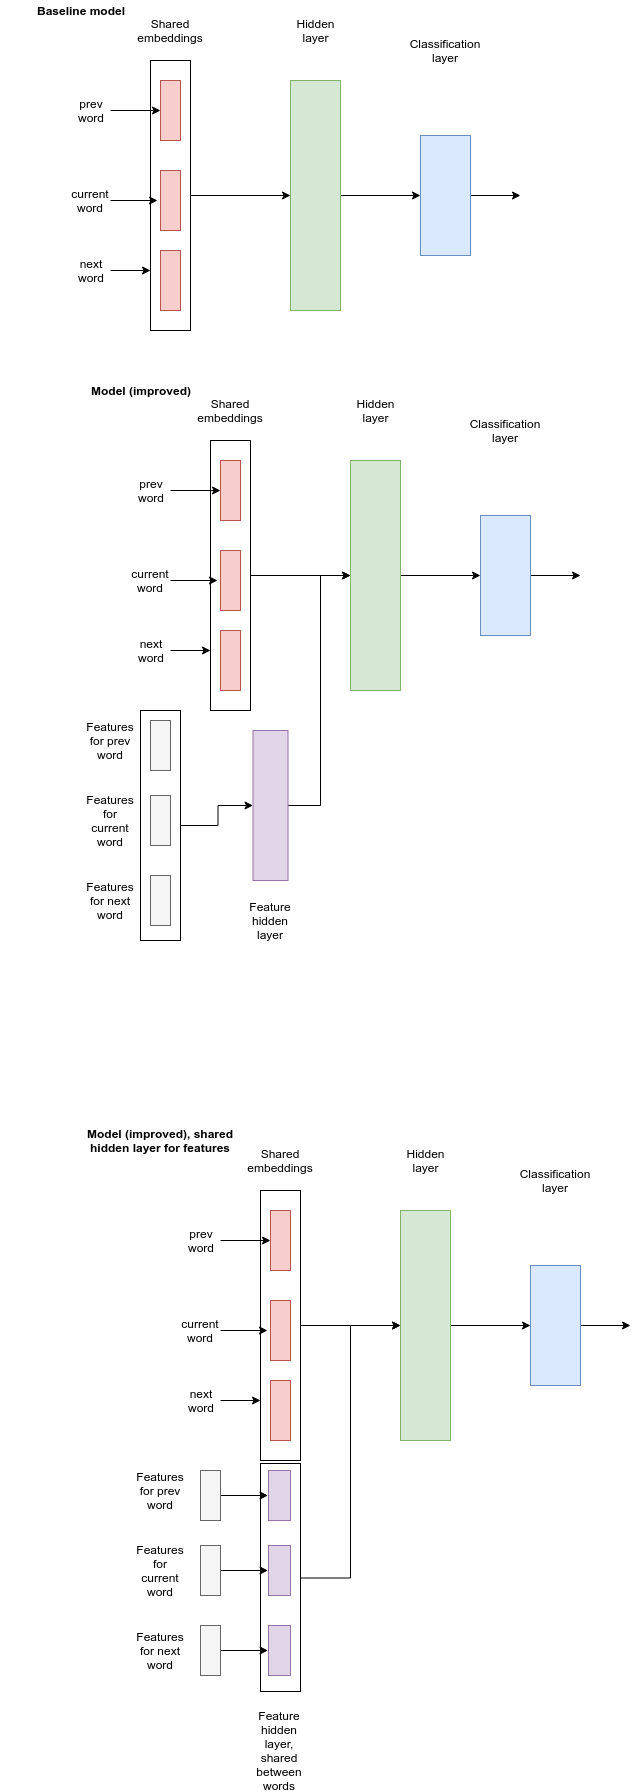

For both models, you only have to add just a few lines. Please copy/paste the relevant parts only, marked below. Also, report the devset accuracy after training for 5 epochs.

The provided notebook has already implemented feature extraction and packing the features into the minibatches. 

First, we will download the data.

In [0]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

In [0]:
!wget -q https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

In [0]:
!wget -q https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa

In [0]:

# Convert the CONLL data to our format
from itertools import chain, groupby
def read_conll(filename):  
    result = []
    f = open(filename)
    lines = (str.strip(line) for line in  f)
    groups = (grp for nonempty, grp in groupby(lines, bool) if nonempty)

    for group in groups:
        group = list(group)

        obs, lbl = zip(*(ln.rsplit(None, 1) for ln in group))
        lbl = [l.lstrip("B-").lstrip("I-") for l in lbl]
        word = [x.split()[0] for x in obs]

        result.append(list(zip(word, lbl)))
    return result

In [0]:
train_data = read_conll("eng.train")
dev_data = read_conll("eng.testa")

In [0]:
from collections import Counter
word_counter = Counter()
for sentence in train_data:
  for word, label in sentence:
    word_counter[word] += 1

In [0]:
vocabulary = {}
vocabulary["<unk>"] = 0
vocabulary["<s>"] = 1
vocabulary["</s>"] = 2
for word in word_counter:
  if word_counter[word] > 1:
    vocabulary[word] = len(vocabulary)
    
label_vocabulary = {}
label_vocabulary["O"] = 0
label_vocabulary["ORG"] = 1
label_vocabulary["LOC"] = 2
label_vocabulary["MISC"] = 3
label_vocabulary["PER"] = 4

The above was exactly as we did the lab. Now, we also extract the word features. 

First, we implement a function that generates 'candidate' features for eac word. We use prefixes and suffixes of length 2 and 3.

In [0]:
from cachetools import cached, LRUCache, TTLCache

@cached(cache={})
def generate_word_feature_candidates(word):
  result = set()
  for i in [2, 3]:
    result.add(word[:i] + "__")
    result.add("__" + word[-i:]) 
  return result

In [0]:
print(generate_word_feature_candidates("Brexit"))

{'Bre__', 'Br__', '__it', '__xit'}


Next, we count the feature occurrences in training data:

In [0]:
feature_counter = Counter()

for sentence in train_data:
  for word, label in sentence:
    features = generate_word_feature_candidates(word)
    for feature in features:
      feature_counter[feature] += 1

Next, we make a feature-to-int mapping for the features that occur at least 50 times:

In [0]:
feature_vocabulary = {}
feature_list = []

feature_threshold =  50
for feature in feature_counter:
  if feature_counter[feature] >= feature_threshold:
    feature_vocabulary[feature] = len(feature_vocabulary)
    feature_list.append(feature)

    

Some info about the kept features:

In [0]:
print(len(feature_vocabulary))
print(list(feature_vocabulary.items())[0:20])
print(feature_list[0:20])

1833
[('-D__', 0), ('__T-', 1), ('__RT-', 2), ('-DO__', 3), ('__ts', 4), ('re__', 5), ('__cts', 6), ('__an', 7), ('__man', 8), ('Ger__', 9), ('Ge__', 10), ('ca__', 11), ('__ll', 12), ('cal__', 13), ('__all', 14), ('to__', 15), ('__to', 16), ('__tt', 17), ('bo__', 18), ('Br__', 19)]
['-D__', '__T-', '__RT-', '-DO__', '__ts', 're__', '__cts', '__an', '__man', 'Ger__', 'Ge__', 'ca__', '__ll', 'cal__', '__all', 'to__', '__to', '__tt', 'bo__', 'Br__']


The next function find the feature IDs for a word. It first generates feature candidates for a word, and then keeps only those that are in our feature vocabulary:

In [0]:
@cached(cache={})
def get_word_feature_ids(word):
  feature_candidates = generate_word_feature_candidates(word)
  result = []
  for feature in feature_candidates:
    feature_id = feature_vocabulary.get(feature, -1)
    if feature_id >= 0:
      result.append(feature_id)
  return result
    

In [0]:
get_word_feature_ids("Brexit")

[19, 57]

In [0]:
print([(i, feature_list[i]) for i in get_word_feature_ids("Tallinn")])

[(125, '__nn'), (639, 'Ta__')]


Now, we include the feature extraction part in our dataset. Nore that now, each data item (word observation) will conists of 3 items: words (left word, current word, right word), features for the left, current and right word, and the label (y):

In [0]:
class NERDataset(Dataset):
    """Name Classification dataset"""

    def __init__(self, data ):
        words = []
        self.features = []
        labels = []
        for sentence in data:
          for i in range(len(sentence)):
            if i > 0:
              prevw = vocabulary.get(sentence[i-1][0], 0)
              prevw_features = get_word_feature_ids(sentence[i-1][0])
            else:
              prevw = vocabulary["<s>"]
              prevw_features = []
            if i+1 < len(sentence):
              nextw = vocabulary.get(sentence[i+1][0], 0)
              nextw_features = get_word_feature_ids(sentence[i+1][0])
            else:
              nextw = vocabulary["</s>"]
              nextw_features = []
            words.append((prevw, vocabulary.get(sentence[i][0], 0), nextw))            
            self.features.append((prevw_features,  get_word_feature_ids(sentence[i][0]), nextw_features))
            
            labels.append(label_vocabulary[sentence[i][1]])
        self.words = torch.from_numpy(np.array(words).astype(int)).long()
        
        self.y = torch.from_numpy(np.array(labels).astype(int)).long()

    def __len__(self):
        return len(self.words)

    def __getitem__(self, index):
        words = self.words[index]
        feature_matrix = torch.zeros(3, len(feature_vocabulary), dtype=torch.uint8)
        for j in range(3):
          for k in self.features[index][j]:
            feature_matrix[j, k] = 1
        
        y = self.y[index]
        
        sample = {'words': words, 'features': feature_matrix, 'y': y}
        return sample

In [0]:
train_dataset = NERDataset(train_data)
dev_dataset = NERDataset(dev_data)

Let's check howour first data item looks like. Note that 'features' is a 3x1833 tensor -- the rows corresponds to previous, current and next word and columns to features. The tensor consists of mostly zeros, only in places where a certain feature is activated there is a one.

In [0]:
train_dataset[0]

{'features': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 'words': tensor([1, 3, 2]),
 'y': tensor(0)}

Next part implement our baseline model that only uses word embeddings Note that the `forward` method actually takes feature tensor as an argument, but it is not used in this model.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class NERNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(NERNN, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, words, features):
        x = self.embeddings(words).view(-1, (embedding_dim * 3))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [0]:
device = 'cpu'
if torch.cuda.is_available():
  device = torch.device('cuda')

print(device)

cuda


The next part implements training and evaluation. It has also been enhanced so that it feeds the feature tensor to the model.

In [0]:
def train(model, num_epochs, train_iter, test_iter):

  optimizer = torch.optim.Adam(model.parameters())

  steps = 0
  best_acc = 0
  last_step = 0
  for epoch in range(1, num_epochs+1):
    print("Epoch %d" % epoch)
    model.train()
    for batch in train_iter:
      words, features, y = batch['words'].to(device), batch['features'].to(device), batch['y'].to(device)

      optimizer.zero_grad()
      output = model(words, features)

      loss = F.nll_loss(output, y)
      loss.backward()
      optimizer.step()

      steps += 1

    print('  Epoch finished, evaluating...')
    train_acc = evaluate("train", train_iter, model)                
    dev_acc = evaluate("test", test_iter, model)

def evaluate(dataset_name, data_iter, model):
  
  model.eval()
  total_corrects, avg_loss = 0, 0
  # the following disables gradient computation for evaluation, as we don't need it
  with torch.no_grad():
    for batch in data_iter:
      words, features, y = batch['words'].to(device), batch['features'].to(device), batch['y'].to(device)

      output = model(words, features)

      loss = F.nll_loss(output, y, reduction='sum').item() # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
      correct = pred.eq(y.view_as(pred)).sum().item()

      avg_loss += loss

      total_corrects += correct

  size = len(data_iter.dataset)
  avg_loss /= size
  accuracy = 100.0 * total_corrects/size
  print('  Evaluation on {} - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(dataset_name,
                                                                     avg_loss, 
                                                                     accuracy, 
                                                                     total_corrects, 
                                                                     size))
  return accuracy                

Let's define some constants that we need for he model:

In [0]:
vocab_size = len(vocabulary)
embedding_dim = 50 # dimensionality of word embeddings
hidden_dim = 100   # dim of hidden layer
output_size = len(label_vocabulary) # number of classes




Now, let's train the baseline model:

In [0]:
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_iter = DataLoader(dev_dataset, batch_size=64, shuffle=True)
model = NERNN(vocab_size, embedding_dim, hidden_dim, output_size).to(device)
train(model, 5, train_iter, dev_iter)


Epoch 1
  Epoch finished, evaluating...
  Evaluation on train - loss: 0.241854  acc: 92.1581%(188525/204567)
  Evaluation on test - loss: 0.276254  acc: 91.1261%(47001/51578)
Epoch 2
  Epoch finished, evaluating...
  Evaluation on train - loss: 0.132812  acc: 95.7892%(195953/204567)
  Evaluation on test - loss: 0.199048  acc: 93.7415%(48350/51578)
Epoch 3
  Epoch finished, evaluating...
  Evaluation on train - loss: 0.085252  acc: 97.3603%(199167/204567)
  Evaluation on test - loss: 0.169264  acc: 94.7323%(48861/51578)
Epoch 4
  Epoch finished, evaluating...
  Evaluation on train - loss: 0.057630  acc: 98.2373%(200961/204567)
  Evaluation on test - loss: 0.160385  acc: 95.2790%(49143/51578)
Epoch 5
  Epoch finished, evaluating...
  Evaluation on train - loss: 0.045062  acc: 98.5755%(201653/204567)
  Evaluation on test - loss: 0.164795  acc: 95.2014%(49103/51578)


Now comes your part:

## Excercise 2

Implement a model that also uses word features. The word features should first be 'flattened' (i.e., the features for the left, center and right words should be concatenated into one single tensor), and the fed through a hidden layer, that has output dimensionality defined by `feature_hidden_dim` constructor argument, a used ReLU nonlinearity. The output from this hidden layer should be concatenated with the word embeddings, and then passed through a common hidden layer (with output dim defined by `hidden_dim`), and the output of this goes to the last layer.

In [0]:
# ==== ex 2 copy/paste begin ====

class NERNN_improved(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, feature_dim, feature_hidden_dim, output_size):
        super(NERNN_improved, self).__init__()
        # Implement this

    def forward(self, words, features):
        # Implement this
      
        x = F.log_softmax(x, dim=1)
        return x
# ==== ex 2 copy/paste begin ====      

Let's train the model. *Please report the dev accuracy after 5 epochs (last line)!*

In [0]:
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_iter = DataLoader(dev_dataset, batch_size=64, shuffle=True)
feature_hidden_dim = 100
model_improved =  NERNN_improved(vocab_size, embedding_dim, hidden_dim,  len(feature_vocabulary), feature_hidden_dim, output_size).to(device)
train(model_improved, 5, train_iter, dev_iter)


## Exercise 3

The third model is similar to the second model, but instead of flattening the features before the hidden layer, the features of the previous, current and next words are each passed though a separate hidden layer with *shared weights*, so that the weights for individual features would be the same, regardless of the word position, and then flattened and concatenated with the embeddings.

In [0]:
# ==== ex 3 copy/paste begin ====

class NERNN_improved_shared(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, feature_dim, feature_hidden_dim, output_size):
        super(NERNN_improved_shared, self).__init__()
        # Implement this

    def forward(self, words, features):
        # Implement this
      
        x = F.log_softmax(x, dim=1)
        return x
# ==== ex 3 copy/paste end ====      

Let's train the model. *Please report the dev accuracy after 5 epochs (last line)!*

In [0]:
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_iter = DataLoader(dev_dataset, batch_size=64, shuffle=True)
feature_hidden_dim = 100
model3 =  NERNN_improved_shared(vocab_size, embedding_dim, hidden_dim,  len(feature_vocabulary), feature_hidden_dim, output_size).to(device)
train(model3, 5, train_iter, dev_iter)




## Some hints

You might need to use torch.cat(..., dim=...) to concatenate tensors.
